<a href="https://colab.research.google.com/github/sanghee0627/-/blob/main/%3Cepoch40%EC%B5%9C%EC%A2%85%EB%B3%B8%3E.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F

import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import torch.optim.lr_scheduler as lr_scheduler

import os
import time
import copy
import glob
import cv2
import shutil

import torchvision.models as models

import torch.optim as optim


from google.colab import files # 데이터 불러오기
file_uploaded=files.upload()   # 데이터 불러오기: chap05/data/fox.zip 파일 선택

Saving fox.zip to fox.zip


In [2]:
!unzip fox.zip -d fox/

Archive:  fox.zip
   creating: fox/fox/
  inflating: fox/fox/.DS_Store       
  inflating: fox/__MACOSX/fox/._.DS_Store  
   creating: fox/fox/test/
   creating: fox/fox/train/
   creating: fox/fox/test/붉은여우/
  inflating: fox/fox/test/.DS_Store  
  inflating: fox/__MACOSX/fox/test/._.DS_Store  
   creating: fox/fox/test/북극여우/
   creating: fox/fox/train/붉은여우/
  inflating: fox/fox/train/.DS_Store  
  inflating: fox/__MACOSX/fox/train/._.DS_Store  
   creating: fox/fox/train/북극여우/
  inflating: fox/fox/test/붉은여우/1080.jpeg  
  inflating: fox/__MACOSX/fox/test/붉은여우/._1080.jpeg  
  inflating: fox/fox/test/붉은여우/1096.jpeg  
  inflating: fox/__MACOSX/fox/test/붉은여우/._1096.jpeg  
  inflating: fox/fox/test/붉은여우/1079.jpeg  
  inflating: fox/__MACOSX/fox/test/붉은여우/._1079.jpeg  
  inflating: fox/fox/test/붉은여우/071859b6aefc21736c70894f9cf5bdf3.jpeg  
  inflating: fox/__MACOSX/fox/test/붉은여우/._071859b6aefc21736c70894f9cf5bdf3.jpeg  
 

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
data_path = 'fox/fox/train'

transform = transforms.Compose([
    transforms.Resize([256, 256]),
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(), #이미지 뒤집기
    transforms.RandomRotation(10),  # 10범위로 랜덤회전(이미지 회전)
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  #적절한 평균 및 표준 편차를 사용한 정규화
])

train_dataset = torchvision.datasets.ImageFolder(
    data_path,
    transform=transform
)

train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=32,
    num_workers=8,
    shuffle=True
)

print(len(train_dataset))

119


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [5]:
test_path = 'fox/fox/test/'

transform = transforms.Compose([
    transforms.Resize([256, 256]),
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(), #이미지 뒤집기
    transforms.RandomRotation(10),  # 10범위로 랜덤회전(이미지 회전)
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  #적절한 평균 및 표준 편차를 사용한 정규화
])

test_dataset = torchvision.datasets.ImageFolder(
    root=test_path,
    transform=transform
)

test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=32,#배치조정
    num_workers=8,
    shuffle=True
)

print(len(test_dataset))

69


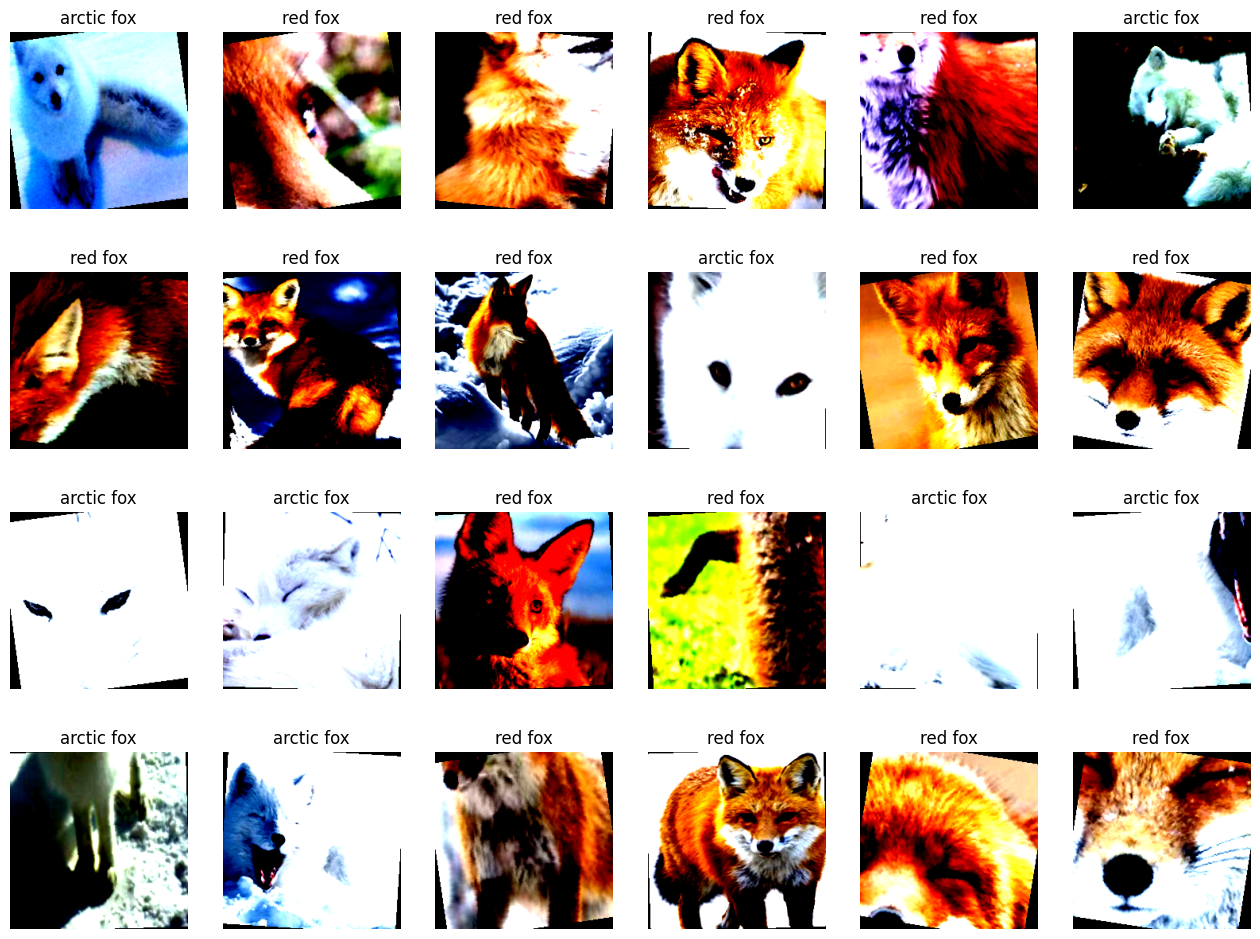

In [6]:
# 데이터셋 체크
samples, labels = next(iter(train_loader))
classes = {0:'arctic fox', 1:'red fox'}
fig = plt.figure(figsize=(16,24))
for i in range(24):
    a = fig.add_subplot(4,6,i+1)
    a.set_title(classes[labels[i].item()])
    a.axis('off')
    a.imshow(np.transpose(samples[i].numpy(), (1,2,0)))
plt.subplots_adjust(bottom=0.2, top=0.6, hspace=0)

In [7]:
resnet18 = torchvision.models.resnet18(pretrained=True)
res = resnet18.fc.in_features
resnet18.fc = nn.Linear(res, 5)

learning_rate = 0.001;#학습률 조정   
optimizer = torch.optim.SGD(resnet18.parameters(), lr=learning_rate, momentum=0.9)#SGD 최적화 알고리즘 사용
criterion = nn.CrossEntropyLoss()

scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1) 

dataloaders = {
    'train': train_loader,
    'eval' : test_loader
}

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 280MB/s]


In [8]:
# 훈련 및 검증 손실 값을 저장할 리스트
train_losses = []
eval_losses = []

# 훈련 및 검증 정확도 값을 저장할 리스트
train_accuracies = []
eval_accuracies = []

# 훈련 반복 횟수를 저장할 변수
total_epochs = 40

# 모델 훈련 루프
for epoch in range(total_epochs):
    print(f"Epoch {epoch+1}/{total_epochs}")
    print("-" * 10)
    
    # 훈련 모드 설정
    resnet18.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    # 훈련 데이터 배치별로 학습
    for inputs, labels in dataloaders['train']:
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        
        outputs = resnet18(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    train_loss = running_loss / len(dataloaders['train'])
    train_acc = correct / total
    
    # 검증 모드 설정
    resnet18.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    # 검증 데이터 배치별로 예측 성능 확인
    with torch.no_grad():
        for inputs, labels in dataloaders['eval']:
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = resnet18(inputs)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    eval_loss = running_loss / len(dataloaders['eval'])
    eval_acc = correct / total
    
    # 훈련 및 검증 손실 값 저장
    train_losses.append(train_loss)
    eval_losses.append(eval_loss)
    
    # 훈련 및 검증 정확도 값 저장
    train_accuracies.append(train_acc)
    eval_accuracies.append(eval_acc)
    
    # 훈련 결과 출력
    print(f"Train Loss: {train_loss:.4f} Train Acc: {train_acc:.4f}")
    print(f"Eval Loss: {eval_loss:.4f} Eval Acc: {eval_acc:.4f}")
    print()
    
    # 학습률 스케줄러 업데이트
    scheduler.step()


Epoch 1/40
----------
Train Loss: 1.4116 Train Acc: 0.3445
Eval Loss: 0.8300 Eval Acc: 0.8406

Epoch 2/40
----------
Train Loss: 0.5828 Train Acc: 0.8403
Eval Loss: 0.3379 Eval Acc: 0.9710

Epoch 3/40
----------
Train Loss: 0.3073 Train Acc: 0.9748
Eval Loss: 0.2167 Eval Acc: 0.9420

Epoch 4/40
----------
Train Loss: 0.1611 Train Acc: 0.9664
Eval Loss: 0.1135 Eval Acc: 0.9855

Epoch 5/40
----------
Train Loss: 0.1116 Train Acc: 0.9832
Eval Loss: 0.0998 Eval Acc: 1.0000

Epoch 6/40
----------
Train Loss: 0.0987 Train Acc: 1.0000
Eval Loss: 0.0889 Eval Acc: 0.9710

Epoch 7/40
----------
Train Loss: 0.1139 Train Acc: 0.9916
Eval Loss: 0.0952 Eval Acc: 0.9855

Epoch 8/40
----------
Train Loss: 0.0976 Train Acc: 0.9832
Eval Loss: 0.1398 Eval Acc: 0.9710

Epoch 9/40
----------
Train Loss: 0.1189 Train Acc: 0.9748
Eval Loss: 0.1377 Eval Acc: 1.0000

Epoch 10/40
----------
Train Loss: 0.1209 Train Acc: 0.9748
Eval Loss: 0.1166 Eval Acc: 1.0000

Epoch 11/40
----------
Train Loss: 0.0842 Train A

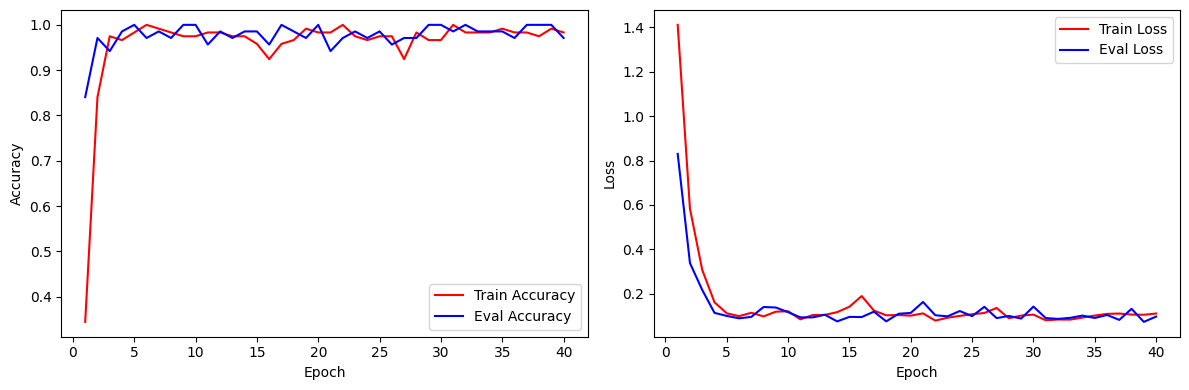

In [9]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(range(1, total_epochs + 1), train_accuracies, label='Train Accuracy', color = 'red')
plt.plot(range(1, total_epochs + 1), eval_accuracies, label='Eval Accuracy', color = 'blue')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, total_epochs + 1), train_losses, label='Train Loss',color = 'red')
plt.plot(range(1, total_epochs + 1), eval_losses, label='Eval Loss', color = 'blue')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()